# Appendix 04 - Exploring Clustering Methods: *Deterministic and Stochastic approaches*

In [52]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from models.deterministic_radially_constrained_cluster import *  # Adjust import as per your package structure
from models.radially_constrained_cluster import *
from models.X_RCC import XRCC
from visualization.custom_plots import standard_format, day_of_year_to_date
import itertools

In [53]:
# -- PARAMETERS 

# Common parameters
n_seas = 4
min_len= 70
metric = 'euclidean'

# Deterministic model parameters
n_days = list(np.arange(0,365,50))

# Stochastic model parameters
iters = 100
learning_rate   = 5

starting_bp     = [50, 330]

lat = 30
lon = 80



In [54]:
dataset_t2m = xr.open_mfdataset(rf'../data/preprocessed/ERA5/2m_temperature/final.nc')['2t'].load().sel(lat=lat, lon=lon, method='nearest')
dataset_tp = xr.open_mfdataset(rf'../data/preprocessed/ERA5/total_precipitation/final.nc').tp.load().sel(lat=lat, lon=lon, method='nearest')
dataset_u100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_u_wind/final.nc').u100.load().sel(lat=lat, lon=lon, method='nearest')
dataset_v100 = xr.open_mfdataset(rf'../data/preprocessed/ERA5/100m_v_wind/final.nc').v100.load().sel(lat=lat, lon=lon, method='nearest')

dataset_tp['time'] = dataset_t2m['time']
dataset_u100['time'] = dataset_t2m['time']
dataset_v100['time'] = dataset_t2m['time']

datasets = [dataset_tp, dataset_t2m, dataset_u100, dataset_v100]  # Add as many datasets as needed

In [55]:
datasets_tab = [dataset.to_dataframe() for dataset in datasets]

datasets_tab = [dataset.dropna() for dataset in datasets_tab]
datasets_tab = pd.concat(datasets_tab, axis=1)

datasets_tab = datasets_tab.drop(columns=['lon','lat','spatial_ref'])
# Remove hours from datetime
datasets_tab.index = pd.to_datetime(datasets_tab.index.astype(str))

In [56]:
# Reshape the table to keep the day of the year as the index and for the columns the values of the different variables at each year.
# The final shape will be 365 * n_years x n_variables. Remove the empy values
datasets_tab_res = datasets_tab.pivot_table(index=datasets_tab.index.dayofyear, columns=datasets_tab.index.year)
datasets_tab_res.columns = [f'{var}_{year}' for var, year in datasets_tab_res.columns]
datasets_tab_res

,2t_1969,2t_1970,2t_1971,2t_1972,2t_1973,2t_1974,2t_1975,2t_1976,2t_1977,2t_1978,...,v100_2009,v100_2010,v100_2011,v100_2012,v100_2013,v100_2014,v100_2015,v100_2016,v100_2017,v100_2018
time,,,,,,,,,,,,,,,,,,,,,
1,274.265900,277.974548,277.377960,279.161041,276.246094,277.335144,274.878967,279.023987,275.549347,273.044067,...,0.331128,0.116477,-0.250850,-0.035245,-0.157469,-0.205075,-0.124114,0.178020,0.169200,-0.011866
2,274.424835,277.881470,277.541016,279.045929,276.460236,277.429047,274.837860,279.031403,275.511566,272.653473,...,0.281977,0.069452,-0.275298,-0.026174,-0.158733,-0.175786,-0.076503,0.174930,0.131651,0.044889
3,274.654938,277.692291,277.695312,278.860504,276.682617,277.662811,274.719513,278.784790,275.721802,272.535431,...,0.210742,0.007395,-0.278118,-0.046850,-0.188935,-0.129802,-0.017632,0.206212,0.138985,0.031185
4,274.952789,277.491394,277.795532,278.749237,276.791199,277.737274,274.523102,278.658142,275.893372,272.711121,...,0.153671,-0.042996,-0.254760,-0.024912,-0.166773,-0.166655,0.044862,0.237814,0.129496,0.014131
5,275.214722,277.218689,277.833954,278.560760,276.704468,277.820496,274.133118,278.592316,275.934082,272.925751,...,0.107614,-0.071817,-0.222469,-0.052481,-0.128905,-0.142412,0.066273,0.251582,0.096203,0.027358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,278.210266,277.724121,279.342346,275.177032,276.148712,274.868469,279.306091,276.094025,273.609802,276.406586,...,0.075706,-0.048348,-0.192864,-0.193044,-0.211862,-0.209635,0.118495,0.307230,-0.119596,0.082552
363,278.160980,277.431915,279.376129,275.368469,276.546783,274.753601,279.202271,276.090454,273.485321,276.341248,...,0.113817,-0.123478,-0.178701,-0.188940,-0.266136,-0.157835,0.131698,0.300738,-0.063779,0.127346
364,278.033142,277.350250,279.217957,275.579956,277.042053,274.694214,279.056641,275.937286,273.484955,276.364532,...,0.138494,-0.180170,-0.092987,-0.206414,-0.265938,-0.062887,0.190252,0.280031,-0.036000,0.189522


In [57]:
dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.min(axis=0))/(datasets_tab_res.max(axis=0) - datasets_tab_res.min(axis=0))
#dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.mean(axis=0))/datasets_tab_res.std(axis=0)
dataset_tab_res_norm

,2t_1969,2t_1970,2t_1971,2t_1972,2t_1973,2t_1974,2t_1975,2t_1976,2t_1977,2t_1978,...,v100_2009,v100_2010,v100_2011,v100_2012,v100_2013,v100_2014,v100_2015,v100_2016,v100_2017,v100_2018
time,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.174713,0.232098,0.314116,0.110856,0.192008,0.053978,0.251816,0.122943,0.026726,...,0.557490,0.289922,0.024511,0.267971,0.088651,0.150136,0.000000,0.313118,0.472728,0.145994
2,0.009541,0.168879,0.241529,0.308082,0.123469,0.197597,0.051634,0.252290,0.120831,0.006202,...,0.526507,0.249605,0.002535,0.275080,0.087620,0.171703,0.040220,0.310685,0.444512,0.197133
3,0.023354,0.157023,0.250453,0.298364,0.136567,0.211512,0.044884,0.236517,0.132582,0.000000,...,0.481602,0.196400,0.000000,0.258877,0.062980,0.205565,0.089953,0.335314,0.450024,0.184785
4,0.041234,0.144433,0.256249,0.292532,0.142962,0.215944,0.033682,0.228417,0.142172,0.009231,...,0.445627,0.153197,0.020996,0.276069,0.081061,0.178427,0.142746,0.360195,0.442893,0.169419
5,0.056958,0.127342,0.258471,0.282654,0.137853,0.220898,0.011439,0.224207,0.144448,0.020509,...,0.416594,0.128488,0.050021,0.254464,0.111953,0.196279,0.160833,0.371035,0.417876,0.181337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.236782,0.159018,0.345710,0.105307,0.105121,0.045181,0.306477,0.064421,0.014529,0.203405,...,0.396480,0.148609,0.076632,0.144312,0.044277,0.146778,0.204949,0.414848,0.255716,0.231069
363,0.233823,0.140705,0.347664,0.115340,0.128566,0.038343,0.300556,0.064192,0.007570,0.199972,...,0.420504,0.084196,0.089362,0.147528,0.000000,0.184922,0.216103,0.409736,0.297658,0.271430
364,0.226149,0.135587,0.338516,0.126425,0.157736,0.034808,0.292250,0.054396,0.007550,0.201195,...,0.436060,0.035591,0.166409,0.133834,0.000161,0.254840,0.265567,0.393434,0.318533,0.327454


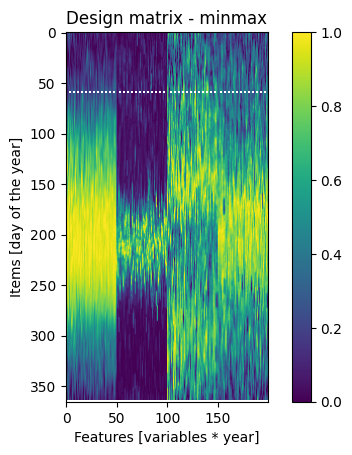

In [58]:
plt.figure()
plt.imshow(dataset_tab_res_norm.values)
plt.xlabel('Features [variables * year]')
plt.ylabel('Items [day of the year]')
plt.title('Design matrix - minmax')
plt.colorbar()

In [59]:
arrays = []

for grid_points_var in datasets:
    grid_points_var = np.asarray(grid_points_var)
    grid_points_var = np.reshape(grid_points_var, (365, int(grid_points_var.size/365)), order='F')
    
    if np.isnan(grid_points_var).any():
        array_tot = (np.full(n_seas, np.nan), np.full(iters, np.nan), np.full(iters, np.nan))
    
    arrays.append(grid_points_var)

combined_mask = ~np.any([np.all(np.isnan(arr), axis=0) for arr in arrays], axis=0)

normalized_arrays = []
for arr in arrays:
    array_tot = arr[:, combined_mask]
    array_tot = (array_tot - array_tot.min(axis=0)) / (array_tot.max(axis=0) - array_tot.min(axis=0))
    #array_tot = (array_tot - array_tot.mean(axis=0)) / array_tot.std(axis=0)
    normalized_arrays.append(array_tot)

    array_tot = np.concatenate(normalized_arrays, axis=1)

In [60]:
from sklearn.metrics import silhouette_score

best, err, bp_list = single_fit_optimized(array_tot, n_seas, n_days, metric=metric)

70it [00:00, 755.95it/s]


In [76]:
best

array([100, 150, 250, 300], dtype=int32)

In [62]:
# Costruisci variabili indipendenti dinamicamente dalle combinazioni
variables = np.array(list(combinations(n_days, n_seas))).T  # Variabili indipendenti in forma (n_dimensions, n_combinations)

# Definiamo X_grid come la meshgrid multidimensionale di ciascuna variabile
unique_vars = [np.unique(var) for var in variables]
grids = np.meshgrid(*unique_vars, indexing='ij')  # Griglia multidimensionale per tutte le variabili

# Creare Z con una dimensione extra per le dimensioni di err
Z = np.empty(grids[0].shape + (n_seas,))  # Z ha le dimensioni della griglia e una dimensione extra per err

# Riempimento di Z con valori medi per ciascuna combinazione unica delle variabili
for index in np.ndindex(grids[0].shape):  # Itera su tutti gli indici della griglia
    # Trova gli indici che corrispondono a ciascuna combinazione di variabili
    indices = np.all([variables[i] == grids[i][index] for i in range(len(variables))], axis=0)
    
    # Calcola la media se esistono valori corrispondenti
    if np.any(indices):
        Z[index] = np.mean(err[indices], axis=0)
    else:
        Z[index] = np.nan  # Riempire con NaN se nessun valore corrisponde

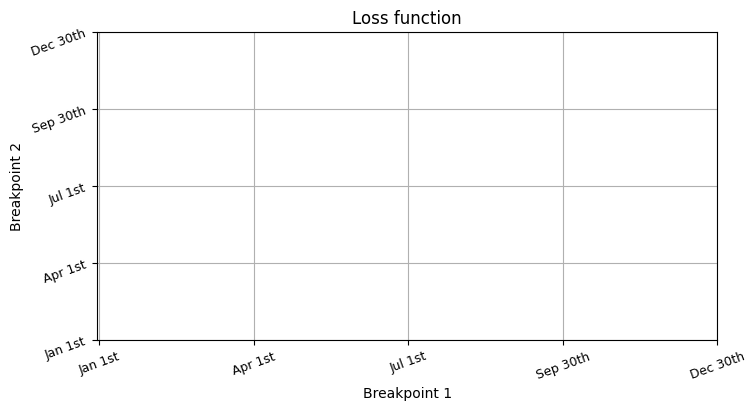

In [71]:
x = np.array(list(combinations(n_days, n_seas))).squeeze()[:,0]
y = np.array(list(combinations(n_days, n_seas))).squeeze()[:,1]


# # Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# # Creare un array per Z con le dimensioni di X e Y
# Z = np.empty(X.shape)

# # Riempire Z con valori medi di z_all raggruppati
# for i in range(len(np.unique(x))):
#     for j in range(len(np.unique(y))):
#         # Trovare i punti che corrispondono a questo (x, y)
#         indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
#         Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

        

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, np.squeeze(Z[:,0,:,0,1]), levels=6, colors='black')
#plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='viridis', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

Text(0, 0.5, 'WCSS')

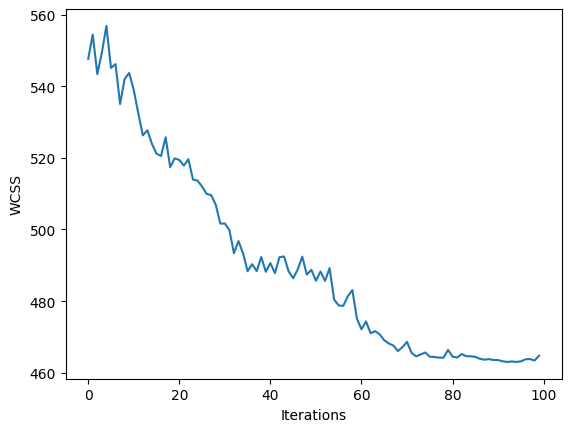

In [79]:
clustering_params = {
        'n_iter': 1000,
        'n_seas': n_seas,
        'learning_rate': 2,
        'scheduling_factor':1,
        'min_len': 1,
        'mode': 'single',
        'starting_bp': list(np.sort(np.random.randint(0, 365, n_seas))),
        'metric': metric,
    }

model = Radially_Constrained_Cluster(array_tot, **clustering_params)

model.fit()

plt.plot(model.error_history)
plt.xlabel('Iterations')
plt.ylabel('WCSS')

In [80]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='viridis', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

plt.plot(model.breakpoint_history[:,0],model.breakpoint_history[:,1], '-o', color='red', lw=0.5, markersize=0.1)

IndexError: index 28 is out of bounds for axis 0 with size 28

In [84]:
model.breakpoints

array([ 99, 148, 177, 274], dtype=int32)

In [82]:
# Import the reference dates

literature_results_path  = f'../data/preprocessed/external/monsoon_dates.nc'
literature_results = xr.open_dataset(literature_results_path).drop('spatial_ref')

/tmp/ipykernel_3567467/1448965862.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  literature_results = xr.open_dataset(literature_results_path).drop('spatial_ref')


In [83]:
literature_results_point = literature_results.sel(lat=lat, lon=lon, method='nearest')
literature_results_point.date.values

array([165.3726268, 273.4096453])

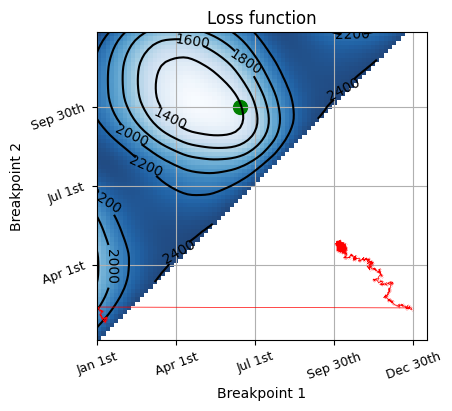

In [54]:
x = np.array(list(combinations(n_days, 2))).squeeze()[:,0]
y = np.array(list(combinations(n_days, 2))).squeeze()[:,1]

# Creare una meshgrid di x e y
X, Y = np.meshgrid(np.unique(x), np.unique(y))

# Creare un array per Z con le dimensioni di X e Y
Z = np.empty(X.shape)

# Riempire Z con valori medi di z_all raggruppati
for i in range(len(np.unique(x))):
    for j in range(len(np.unique(y))):
        # Trovare i punti che corrispondono a questo (x, y)
        indices = (x == X[j, i]) & (y == Y[j, i])  # Aggiorna per la tua logica
        Z[j, i] = np.mean([err[k] for k in range(len(err)) if indices[k]]) if np.any(indices) else np.nan  # Media dei valori corrispondenti

# Creare il grafico a contorni riempiti
plt.figure(figsize=(8, 4))
contour= plt.contour(X, Y, Z, levels=6, colors='black')
plt.imshow(Z, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', cmap='Blues', alpha=0.9)


ax = plt.gca()
ax.clabel(contour, inline=True, fontsize=10)

#plt.colorbar(contour)
plt.title('Loss function')
plt.xlabel('Breakpoint 1')
plt.ylabel('Breakpoint 2')
plt.grid()

# .
ax = plt.gca()
ax.set_xticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)
ax.set_yticks(ticks=np.linspace(1,365,5), labels=[day_of_year_to_date(x) for x in np.linspace(1,365,5)], rotation=20, fontsize=9)

plt.plot(model.breakpoint_history[:,0],model.breakpoint_history[:,1], '-o', color='red', lw=0.5, markersize=0.1)
plt.scatter(literature_results_point.date.values[0], literature_results_point.date.values[1], marker='o', color='green', s=100)